Informations:
* Data collecting tool: **Rsyslog**  
* Features extraction tool: **Drain**

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import json
import numpy as np

folder = os.path.join("..", "0_dataset", "syslog")
filename = 'original_label_syslog.csv'
filename_label = 'preprocess_label_syslog.csv'
filename_label_lifecycle = "lifecycle_"+filename_label
filename_sequence_1sec = "fix_1sec.csv"

# for lifecycle labeling
filenames = [['label_syslog_disk_wipe.csv', 2],
               ['label_syslog_end_point_dos.csv', 5],
               ['label_syslog_mirai.csv', 1],
               ['label_syslog_ransomware.csv', 3],
               ['label_syslog_resource_hijacking.csv', 4]]

Preprocessing (vector conuting)

In [2]:
col_list = ['HostName', 'EventTemplate', 'Timestamp', 'Label']
one_hot_col_list = ['EventTemplate']
# del_col_list = ['HostName', 'Timestamp']
del_col_list = ['HostName']
df = pd.read_csv(os.path.join(folder, filename), usecols=col_list)
labels = sorted(df['Label'].unique())

print('label uniques: {0}'.format(labels))
print('number of timestamp: {0}'.format(len(df['Timestamp'].unique())))

df = pd.get_dummies(df, columns=one_hot_col_list)

hostnames = df['HostName'].unique()

# simple analysis
for tmp_filename, label in filenames:
    print("\n")
    print("-------------------------------------\n")
    print("file name:{0}".format(tmp_filename))
    tmp_filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(tmp_filename)

    # simple analysis
    tmp_labels = sorted(tmp_df['Label'].unique())
    print('labels: {0}'.format(tmp_labels))

df_count_vector = pd.DataFrame()

df_machines = []
unique_timestamps_machines = []
for hostname in hostnames:
    df_machines.append(df[df['HostName'] == hostname])

for df_machine in df_machines:
    unique_timestamps = list(set(df_machine['Timestamp']))
    unique_timestamps_machines.append(unique_timestamps)

# record templates by each second and machine
for i in range(len(df_machines)):
    df_machine = df_machines[i]
    tmp_unique_timestamps = unique_timestamps_machines[i]
    for tmp_timestamp in tmp_unique_timestamps:
        tmp_df = df_machine[df_machine['Timestamp'] == tmp_timestamp]
        tmp_df = tmp_df.drop(columns=del_col_list)
        classes_num = {}
        for j in labels:
            class_num = len(tmp_df[tmp_df['Label'] == j])
            if j != 0 and class_num > 0:
                classes_num[j] = class_num
        sum_one_hot = tmp_df.sum()
        
        # label according to most frequent technique
        max_num = 0
        max_label = 0
        for key in classes_num:
            if classes_num[key] > max_num:
                max_num = classes_num[key]
                max_label = key
            
        sum_one_hot = pd.DataFrame(sum_one_hot).transpose()
        sum_one_hot['Label'] = max_label
        sum_one_hot['Timestamp'] = tmp_timestamp
        
        df_count_vector = pd.concat([df_count_vector, sum_one_hot], ignore_index=True)
        
output_file = os.path.join(folder, filename_label)
df_count_vector.to_csv(output_file, encoding='utf-8', index=False)

label uniques: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
number of timestamp: 6713


-------------------------------------

file name:label_syslog_mirai.csv
labels: [0, 1, 2, 3, 9, 11, 13]


-------------------------------------

file name:label_syslog_disk_wipe.csv
labels: [0, 1, 2, 4, 6, 8, 14]


-------------------------------------

file name:label_syslog_ransomware.csv
labels: [0, 1, 2, 4, 6, 7, 12, 15]


-------------------------------------

file name:label_syslog_resource_hijacking.csv
labels: [0, 1, 2, 4, 6, 8, 16]


-------------------------------------

file name:label_syslog_end_point_dos.csv
labels: [0, 1, 2, 4, 8, 10, 17]


KeyboardInterrupt: 

clean data from benign server

In [5]:
df = pd.read_csv(os.path.join(folder, filename))
df.loc[df['HostName'] == '192.168.56.171', 'Label'] = 0
df.to_csv(os.path.join(folder, 'fix.csv'), encoding='utf-8', index=False)

In [6]:
# df = pd.read_csv(os.path.join(folder, 'old.csv'))
df = pd.read_csv(os.path.join(folder, 'fix.csv'))
print(df['HostName'].unique())
for host in df['HostName'].unique():
    print('{}: {}'.format(host, sorted(df.loc[df['HostName'] == host, 'Label'].unique())))
# print(sorted(df.loc[df['HostName'] == '192.168.56.171', 'Label'].unique()))

['192.168.56.171' 'target-server' 'vulnerable-machine-1'
 'non-vulnerable-machine-1' 'non-vulnerable-machine-2']
192.168.56.171: [0]
target-server: [0, 1, 2, 4, 6, 7, 8, 10, 12, 14, 15, 16, 17]
vulnerable-machine-1: [0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
non-vulnerable-machine-1: [0]
non-vulnerable-machine-2: [0]


label encoding for event templates

In [16]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(os.path.join(folder, 'fix.csv'))
labelencoder = LabelEncoder()
df['EventTemplate'] = labelencoder.fit_transform(df['EventTemplate'])
df.to_csv(os.path.join(folder, 'fix.csv'), encoding='utf-8', index=False)

unique_num = len(df['EventTemplate'].unique())
print(f'num of diff labels in template: {unique_num}')

num of diff labels in template: 91


merge templates and labels by second

In [15]:
df = pd.read_csv(os.path.join(folder, 'fix.csv'))
df = df.loc[:, ['EventTemplate', 'Label', 'Timestamp']]

df_merged = pd.DataFrame()
for t in df['Timestamp'].unique():
    df_tmp = df[df['Timestamp'] == t]
    
    voting_label = {}
    for label in df_tmp['Label'].values:
        if label in voting_label:
            voting_label[label] += 1
        else:
            voting_label[label] = 1
    
    if len(voting_label) == 1 and 0 in voting_label:
        new_label = 0
    else:
        new_label = max(voting_label, key=voting_label.get)
    
    # df_str = df_tmp.groupby('Timestamp')['EventTemplate'].apply(lambda x: ' '.join(x)).reset_index()
    df_str = df_tmp.groupby('Timestamp')['EventTemplate'].agg(lambda x: list(x.astype(int))).reset_index()
    df_str['Label'] = new_label
    df_merged = pd.concat([df_merged, df_str], ignore_index=True)


output_file = os.path.join(folder, filename_sequence_1sec)
df_merged.to_csv(output_file, encoding='utf-8', index=False)


max_length = 0
for i in df_merged['EventTemplate']:
    if len(i) > max_length:
        max_length = len(i)
        
print(f'max length: {max_length}')
print(df_merged)

max length: 1536
         Timestamp                                      EventTemplate  Label
0     1.673431e+09  [66, 4, 4, 4, 4, 4, 4, 4, 3, 4, 60, 68, 59, 4,...      0
1     1.673431e+09            [65, 59, 68, 60, 3, 59, 68, 66, 65, 60]      0
2     1.673431e+09  [65, 65, 65, 66, 65, 65, 3, 4, 4, 4, 4, 4, 4, ...      0
3     1.673431e+09  [66, 68, 60, 59, 68, 60, 65, 66, 65, 65, 59, 6...      0
4     1.673431e+09  [66, 4, 65, 65, 65, 65, 66, 65, 4, 4, 4, 4, 4,...      0
...            ...                                                ...    ...
6708  1.673441e+09  [66, 66, 70, 60, 68, 59, 65, 65, 65, 66, 65, 6...      0
6709  1.673441e+09  [4, 65, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,...     17
6710  1.673441e+09  [3, 58, 65, 65, 66, 65, 60, 68, 59, 65, 66, 61...      0
6711  1.673441e+09  [4, 4, 3, 4, 4, 4, 59, 4, 4, 4, 4, 4, 4, 4, 4,...     17
6712  1.673441e+09  [65, 66, 65, 65, 66, 65, 59, 68, 60, 65, 66, 6...      0

[6713 rows x 3 columns]


re-label to lifecycle

In [10]:
df = pd.read_csv(os.path.join(folder, filename_sequence_1sec))

for filename, label_lifecycle in filenames:
    df_tmp = pd.read_csv(os.path.join(folder, filename))
    t_start = df_tmp['Timestamp'].iloc[0]
    t_end = df_tmp['Timestamp'].iloc[-1]
    df.loc[(df['Timestamp'] >= t_start) & (df['Timestamp'] <= t_end) & (df['Label'] != 0), 'Label'] = label_lifecycle

output_file = os.path.join(folder, 'lifecycle_'+filename_sequence_1sec)
df.to_csv(output_file, encoding='utf-8', index=False)
print(f'lifecycle labels: {sorted(df["Label"].unique())}')
print(df.info)

lifecycle labels: [0, 1, 2, 3, 4, 5]
<bound method DataFrame.info of          Timestamp                                      EventTemplate  Label
0     1.673431e+09  [66, 4, 4, 4, 4, 4, 4, 4, 3, 4, 60, 68, 59, 4,...      0
1     1.673431e+09            [65, 59, 68, 60, 3, 59, 68, 66, 65, 60]      0
2     1.673431e+09  [65, 65, 65, 66, 65, 65, 3, 4, 4, 4, 4, 4, 4, ...      0
3     1.673431e+09  [66, 68, 60, 59, 68, 60, 65, 66, 65, 65, 59, 6...      0
4     1.673431e+09  [66, 4, 65, 65, 65, 65, 66, 65, 4, 4, 4, 4, 4,...      0
...            ...                                                ...    ...
6708  1.673441e+09  [66, 66, 70, 60, 68, 59, 65, 65, 65, 66, 65, 6...      0
6709  1.673441e+09  [4, 65, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,...      5
6710  1.673441e+09  [3, 58, 65, 65, 66, 65, 60, 68, 59, 65, 66, 61...      0
6711  1.673441e+09  [4, 4, 3, 4, 4, 4, 59, 4, 4, 4, 4, 4, 4, 4, 4,...      5
6712  1.673441e+09  [65, 66, 65, 65, 66, 65, 59, 68, 60, 65, 66, 6...      0

[6713 

data cleaning

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

# df = pd.read_csv(os.path.join(folder, filename))
df = pd.read_csv(os.path.join(folder, "fix_" + filename))
# df = pd.read_csv(os.path.join(folder, 'fix.csv'))
df = df.loc[:, ['EventTemplate', 'Label', 'Timestamp']]
del_list = ['Timestamp']
max_threshold = 50000
min_threshold = 20

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# data cleaning
# df.drop(columns=del_list, inplace=True)

for label in df['Label'].unique():
    # # if too much, try drop duplicated first
    # if len(df[df['Label'] == label]) > max_threshold:
    #     df_tmp = df.loc[df['Label'] == label].copy()
    #     df_tmp.drop_duplicates(keep='last', inplace=True)
    #     df.drop(df[df['Label'] == label].index, inplace=True)
    #     df = pd.concat([df, df_tmp], ignore_index=True)

    # if too few, double their number until it's enough
    while len(df[df['Label'] == label]) < min_threshold:
        tmp_df = df[df['Label'] == label]
        df = pd.concat([df, tmp_df], ignore_index=True)


# # feature scaling
# y_tmp = df['Label']
# df.drop(columns=['Label'], inplace=True)
# for feature in df.columns.values:
#     # scaler = RobustScaler().fit(df[feature].values.reshape(-1, 1))
#     scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
#     # scaler = Normalizer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = QuantileTransformer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = PowerTransformer().fit(df[feature].values.reshape(-1, 1))
#     df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
# df = pd.concat([df, y_tmp], axis=1, ignore_index=True)


# # feature selection
# # delete features with all the same value
# y_tmp = df['Label']
# y = df['Label'].values.astype(int)
# df.drop('Label', axis=1, inplace=True)
# selector = VarianceThreshold(threshold=0)
# selector.fit(df)
# # print(selector.variances_)
# constant_columns = [column for column in df.columns
#                     if column not in 
#                     df.columns[selector.get_support()]]
# df.drop(labels=constant_columns, axis=1, inplace=True)

# # delete similar features
# df_tmp = df
# corr_features = set()
# corr_matrix = df_tmp.corr()
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if abs(corr_matrix.iloc[i, j]) > 0.9:
#             colname = corr_matrix.columns[i]
#             corr_features.add(colname)
# df.drop(labels=corr_features, axis=1, inplace=True)

# df = pd.concat([df, y_tmp], axis=1, ignore_index=True)


# # balancing extremly few class
# for class_label in df['Label'].unique():
#     while len(df[df['Label'] == class_label]) < 50:
#         tmp_df = df[df['Label'] == class_label]
#         df = pd.concat([df, tmp_df], ignore_index=True)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, "preprocess_"+filename)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 6713
origin features: 2
remain data number: 6744
remain features: 2


analysis: data number


Data number:
class0: 2572
class1: 91
class2: 917
class3: 1031
class4: 1047
class5: 1055
normal data: 2572
malicious data: 4141
Index(['Timestamp', 'EventTemplate', 'Label'], dtype='object')


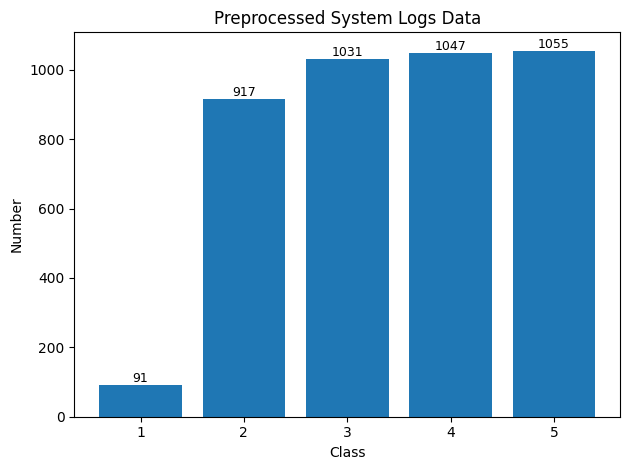

In [12]:
def bar_class_num(technique_data_size):
    class_num = np.arange(len(technique_data_size))
    # data_nums = plt.bar(class_num, technique_data_size, 0.2)
    data_nums = plt.bar(class_num, technique_data_size)
    for item in data_nums:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
            fontsize = 9,
        )
    labels.pop(0)
    plt.xticks(class_num, labels)
    plt.xlabel("Class")
    plt.ylabel("Number")
    plt.title("Preprocessed System Logs Data")
    # plt.title("Raw System Log Data")
    plt.tight_layout()
    plt.savefig("log.png", dpi=400)
    plt.show()

# df = pd.read_csv(os.path.join(folder, filename))
# df = pd.read_csv(os.path.join(folder, "preprocess_"+filename))
# df = pd.read_csv(os.path.join(folder, 'fix.csv'))
df = pd.read_csv(os.path.join(folder, 'lifecycle_'+filename_sequence_1sec))

technique_data_size = []
labels = sorted([int(i) for i in df['Label'].unique()])

print("\nData number:")
for i in labels:
    num = len(df[df['Label'] == i])
    if i != 0:
        technique_data_size.append(num)
    print("class{0}: {1}".format(i, num))


print("normal data: {}".format(len(df[df['Label'] == 0])))
print("malicious data: {}".format(len(df) - len(df[df['Label'] == 0])))
print(df.columns)

bar_class_num(technique_data_size)

analysis: EventTemplate

In [28]:
# df = pd.read_csv(os.path.join(folder, 'test_binary.csv'))
# df = pd.read_csv(os.path.join(folder, 'old', 'label_syslog_structured.csv'))
# df = pd.read_csv(os.path.join(folder, "preprocess_"+filename))
df = pd.read_csv(os.path.join(folder, 'fix.csv'))
df_tmp = df.loc[:, ['Label']]
df = df.loc[:, ['EventTemplate', 'Label', 'Timestamp']]

templates = df['EventTemplate'].unique()
conflict = 0
conflict_names = []

for template in templates:
    df_tmp = df[df['EventTemplate'] == template]
    if len(df_tmp['Label'].unique()) > 1:
        conflict += 1
        conflict_names.append(template)

print('Template types number: {}'.format(len(templates)))
print('Template with multiple labels: {}\n\n'.format(conflict))
for name in conflict_names:
    print(name)

Template types number: 91
Template with multiple labels: 27


localhost (<*>[<*>]) - USER <*> Login successful.
"GET <*> <*> 200 <*> "-" <*>
"GET /chat/read_log.php HTTP/1.1" 404 <*> "about:blank" "Node.js (linux; U; rv:v4.9.1) AppleWebKit/537.36 (KHTML, like Gecko)"
disconnect from unknown[<*>]
lost connection after <*> from unknown[<*>]
connect from unknown[<*>]
localhost (<*>[<*>]) - FTP session <*>
"POST /chat/post.php HTTP/1.1" 404 <*> "about:blank" "Node.js (linux; U; rv:v4.9.1) AppleWebKit/537.36 (KHTML, like Gecko)"
Connection closed by <*> [preauth]
connect from <*> (<*>)
doit: getaddrinfo: Name or service not known
pam_nologin(login:auth): cannot determine username
statistics: max cache size <*> at Jan 11 <*>
statistics: max connection <*> <*> for <*> at Jan 11 <*>
pam_unix(cron:session): session opened for user root by (uid=0)
(root) CMD ( [ -x /usr/lib/php5/maxlifetime ] && [ -x /usr/lib/php5/sessionclean ] && [ -d /var/lib/php5 ] && /usr/lib/php5/sessionclean /var/lib/php5

(test) convert label to binary

In [3]:
df = pd.read_csv(os.path.join(folder, "preprocess_"+filename))
df_tmp = df.loc[:, ['Label']]
df.drop(columns=['Label'], inplace=True)
change_list = df_tmp['Label'].unique().tolist()
change_list.remove(0)
df_tmp['Label'] = np.where(df_tmp['Label'].isin(change_list), 1, df_tmp['Label'])
df = pd.concat([df, df_tmp], axis=1, ignore_index=True)
print(df)
df.to_csv(os.path.join(folder, 'test_binary.csv'), encoding='utf-8', index=False)

                                           EventTemplate     Timestamp  Label
0      localhost (<*>[<*>]) - USER <*> Login successful.  1.673431e+09      1
1                 localhost (<*>[<*>]) - FTP session <*>  1.673431e+09      1
2      localhost (<*>[<*>]) - USER <*> Login successful.  1.673431e+09      1
3                 localhost (<*>[<*>]) - FTP session <*>  1.673431e+09      1
4                 localhost (<*>[<*>]) - FTP session <*>  1.673431e+09      1
...                                                  ...           ...    ...
85271             localhost (<*>[<*>]) - FTP session <*>  1.673431e+09      1
85272             localhost (<*>[<*>]) - FTP session <*>  1.673431e+09      1
85273             localhost (<*>[<*>]) - FTP session <*>  1.673431e+09      1
85274  localhost (<*>[<*>]) - USER <*> Login successful.  1.673431e+09      1
85275  localhost (<*>[<*>]) - USER <*> Login successful.  1.673431e+09      1

[85276 rows x 3 columns]
